In [1]:
%pip install scikit-learn numpy pandas matplotlib tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.datasets import load_breast_cancer
import numpy as np
import pandas as pd

X, Y = load_breast_cancer(return_X_y=True)
Y[Y == 0] = -1

print(f"X shape: {X.shape}")
print(f"y shape: {Y.shape}")
print(f"Classes: {np.unique(Y)}")

X shape: (569, 30)
y shape: (569,)
Classes: [-1  1]


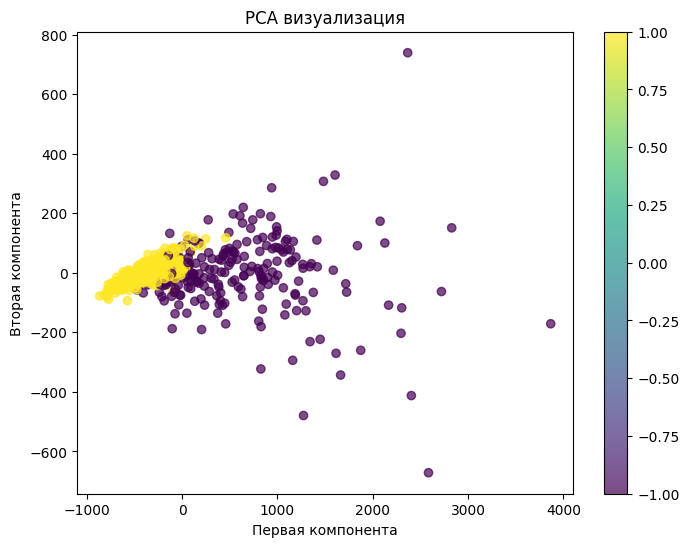

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('PCA визуализация')
plt.xlabel('Первая компонента')
plt.ylabel('Вторая компонента')
plt.show()


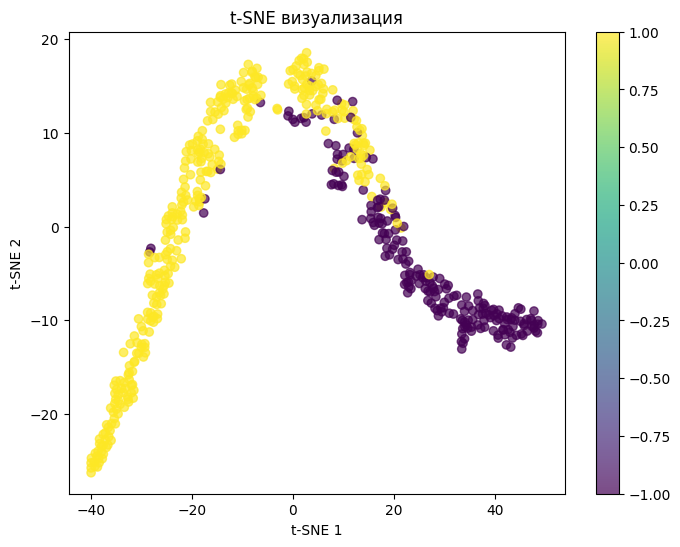

In [4]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('t-SNE визуализация')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

model = SGDClassifier(
    loss='log_loss',
    penalty='l2', 
    alpha=0.01,
    max_iter=1,
    tol=None,
    random_state=42
)

n_epochs = 1000
for epoch in range(n_epochs):
    model.partial_fit(X_train, y_train, classes=np.unique(y_train))

y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print()
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.3f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.3f}")

Confusion Matrix:
[[ 56   7]
 [  2 106]]

Accuracy: 0.947
Precision: 0.948
Recall: 0.947
F1-score: 0.947


In [13]:
import matplotlib.pyplot as plt
from source.sgd_classifier import SimpleSGDClassifier
from source.optimizers import NAGOptimizer, MomentumOptimizer, SGDOptimizer

class LossTracker:
    def __init__(self):
        self.losses = []
        self.test_losses = []

    def callback(self, Q):
        if len(self.losses) % 100 == 0:
            test_margin = y_test * (np.hstack([X_test, np.ones((X_test.shape[0], 1))]) @ sgd.w)
            test_loss = sgd.loss.loss(test_margin).sum() / len(X_test)
            self.test_losses.append(test_loss)
        self.losses.append(Q)

sgd = SimpleSGDClassifier(optimizer=SGDOptimizer(), weight_init="corr")
tracker = LossTracker()

sgd.fit(X_train, y_train, tracker.callback)


100%|██████████| 100/100 [00:00<00:00, 322.83it/s]


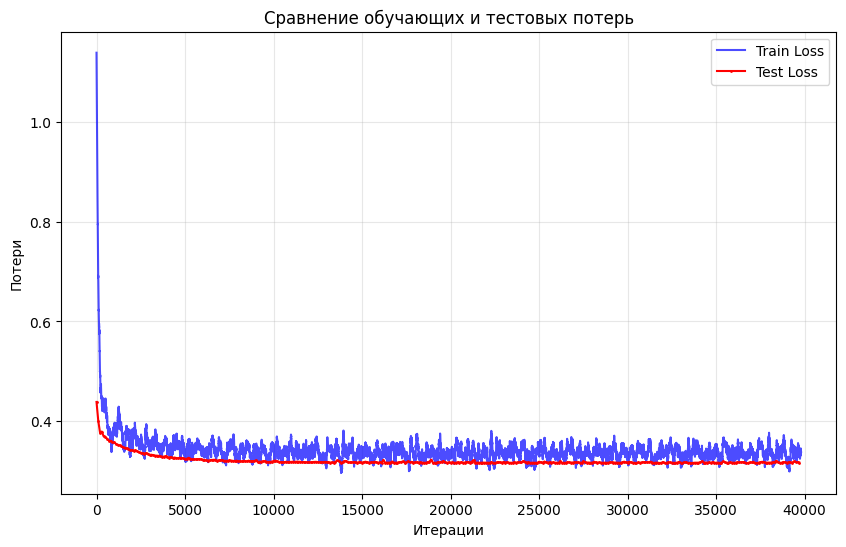

In [14]:
plt.figure(figsize=(10, 6))

plt.plot(tracker.losses, label='Train Loss', color='blue', alpha=0.7)

test_x = [i * 100 for i in range(len(tracker.test_losses))]
plt.plot(test_x, tracker.test_losses, label='Test Loss', color='red', marker='o', markersize=1)

plt.xlabel('Итерации')
plt.ylabel('Потери')
plt.title('Сравнение обучающих и тестовых потерь')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

preds = sgd.predict(X_test)

cm = confusion_matrix(y_test, preds)
print("Confusion Matrix:")
print(cm)

accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy:.3f}")

f1 = f1_score(y_test, preds, average='weighted')
print(f"F1-score: {f1:.3f}")

precision = precision_score(y_test, preds, average='weighted')
recall = recall_score(y_test, preds, average='weighted')
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")


Confusion Matrix:
[[ 56   7]
 [  3 105]]
Accuracy: 0.942
F1-score: 0.941
Precision: 0.942
Recall: 0.942


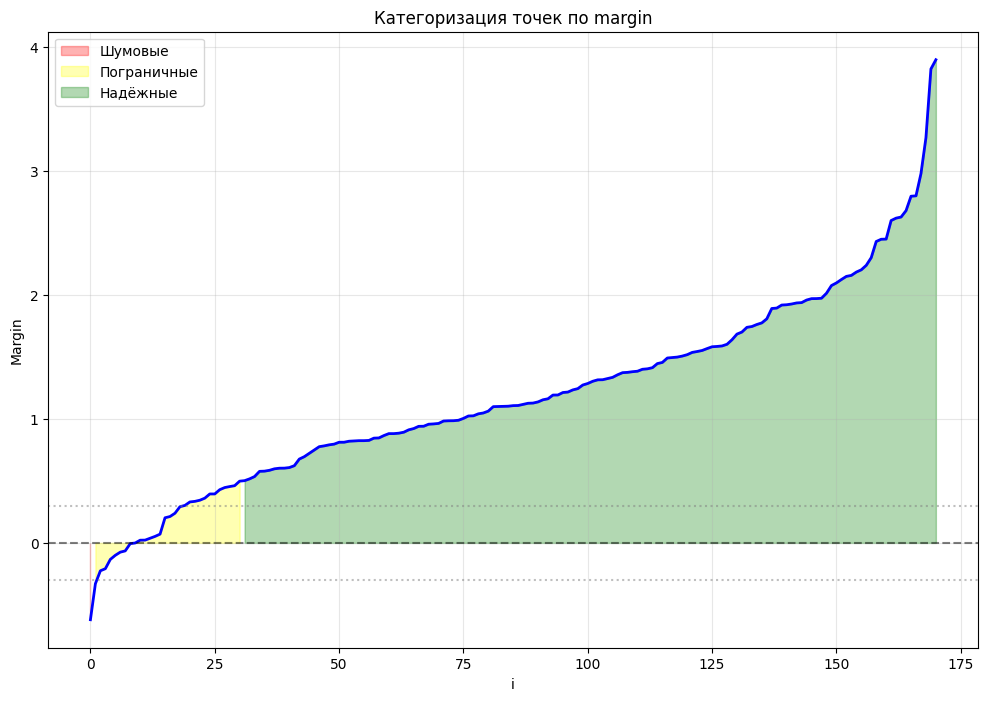

In [10]:
margins = y_test * (np.hstack([X_test, np.ones((X_test.shape[0], 1))]) @ sgd.w)
sorted_indices = np.argsort(margins)
sorted_margins = margins[sorted_indices]

plt.figure(figsize=(12, 8))
plt.plot(range(len(sorted_margins)), sorted_margins, 'b-', linewidth=2)

n_points = len(sorted_margins)
x_range = np.arange(n_points)

threshold = 0.5
noisy_mask = sorted_margins < -threshold  
borderline_mask = (sorted_margins >= -threshold) & (sorted_margins <= threshold)
reliable_mask = sorted_margins > threshold

if np.any(noisy_mask):
    plt.fill_between(x_range[noisy_mask], sorted_margins[noisy_mask], 0, 
                     color='red', alpha=0.3, label='Шумовые')

if np.any(borderline_mask):
    plt.fill_between(x_range[borderline_mask], sorted_margins[borderline_mask], 0, 
                     color='yellow', alpha=0.3, label='Пограничные')

if np.any(reliable_mask):
    plt.fill_between(x_range[reliable_mask], sorted_margins[reliable_mask], 0, 
                     color='green', alpha=0.3, label='Надёжные')

plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.axhline(y=0.3, color='gray', linestyle=':', alpha=0.5)
plt.axhline(y=-0.3, color='gray', linestyle=':', alpha=0.5)

plt.xlabel('i')
plt.ylabel('Margin')
plt.title('Категоризация точек по margin')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()